In [21]:
import os
import sys
import pickle
import pathlib
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cycler import cycler
import numpy as np
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression
from TVRegDiff import TVRegDiff
from mpl_settings_v3 import *
from auxiliary import get_base_network_name

%matplotlib inline
    
meank = 5

fig_dir = '../draft/figs'
net_dir_name = '../networks/ER/ER_k{:.2f}'.format(meank)


attack_dict = {'Ran': r'$\mathrm{Rnd}$', 'Deg': r'$\mathrm{ID}$', 'DegU': r'$\mathrm{RD}$',
               'Btw': r'$\mathrm{IB}$', 'BtwU': r'$\mathrm{RB}$'}

N_values_dict = {
    #'Ran': [2000, 4000, 8000, 16000, 32000, 64000], 
    #'Deg': [2000, 4000, 8000, 16000, 32000, 64000],
    #'DegU': [32000, 64000],
    #'DegU': [2000, 4000, 8000, 16000, 32000, 64000],
    #'Btw': [2000, 4000, 8000, 16000, 32000],
    #'BtwU': [1000, 2000, 3000, 4000, 8000]
    #'BtwU': [1000, 2000, 3000, 4000, 6000, 8000]
    'Deg': [8000],
    'DegU': [8000],
    'Btw': [8000]
}

fminmax_values = {'Ran': (0.72, 0.87), 'Deg': (0.4, 0.55), 'DegU': (0.315, 0.38),
               'Btw': (0.4, 0.65), 'BtwU': (0.26, 0.32)}

#attacks = ['Ran', 'Deg', 'DegU', 'Btw', 'BtwU']
attacks = ['Deg', 'Btw']

def load_dataframe(attack, size, param, net_type='ER', fast=False, n_seeds=None):
    dir_name = os.path.join('../networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    if fast:
        base_csv_file_name = '{}_nSeeds{:d}_cpp.csv'.format(attack, n_seeds)
    else:
        base_csv_file_name = '{}_cpp.csv'.format(attack)
    csv_file_name = os.path.join(dir_name, base_net_name, base_net_name_size, base_csv_file_name)
    df = pd.read_csv(csv_file_name, index_col=0)
    return df

def load_dfs(attack, N_values, meank):

    dfs1000 = {}
    dfs10000 = {}
    dfs20000 = {}
    dfs50000 = {}
    for N in N_values:
        dfs1000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=1000)
        try:
            dfs10000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=10000)
        except:
            pass
        try:
            dfs20000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=20000)
        except:
            pass
        try:
            dfs50000[N] = load_dataframe(attack, N, meank, fast=True, n_seeds=50000)
        except:
            pass

    dfsMax = {}
    for N in N_values:
        if N in dfs50000:
            dfsMax[N] = dfs50000[N]
        elif N in dfs20000:
            dfsMax[N] = dfs20000[N]
        elif N in dfs10000:
            dfsMax[N] = dfs10000[N]
        else:
            dfsMax[N] = dfs1000[N]
            
    return dfs1000, dfs10000, dfs20000, dfsMax

def get_deriv_log(dfs, N, measure, fmin, fmax, overwrite=False, **kwargs):

    f = dfs[N].f.values[int(N*fmin):int(N*fmax)]
    dx = f[1] - f[0]
    values = dfs[N][measure].values[int(N*fmin):int(N*fmax)]
    if 'Ngcc':
        values = values / N
    testf = np.log(values)
    deriv_lrg = TVRegDiff(testf, **kwargs, dx=dx)
    deriv_lrg_np = np.gradient(testf, dx)
    return np.array([f, deriv_lrg, deriv_lrg_np])

In [22]:
overwrite = True

derivs_attack = {}
for attack in attacks:
    N_values = N_values_dict[attack]
    print(attack, N_values)

    _, _, _, dfs = load_dfs(attack, N_values, meank)

    fmin, fmax = fminmax_values[attack]
    measure = 'Sgcc'
    args = dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0)   
    #args = dict(itern=200, alph=1e-4, ep=1e-1, scale='large', plotflag=0, diagflag=0)   

    derivs_dict = {}
    for N in N_values:
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        print(network)
        #base_file_name = 'TVRegDiff_{}_itern{}_alph{}_ep{}.txt'.format(attack, args['itern'], args['alph'], args['ep'])
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], 
                                                                                             args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)
        if os.path.isfile(data_file) and not overwrite:
            print('Reading previous data')
            derivs = np.loadtxt(data_file)
        else:
            derivs = get_deriv_log(dfs, N, measure, fmin, fmax, **args)
            np.savetxt(data_file, derivs)
        derivs_dict[N] = derivs
    derivs_attack[attack] = derivs_dict


Deg [8000]
ER_k5.00_N8000
Btw [8000]
ER_k5.00_N8000


Deg
DegU
Btw
BtwU
Deg
Deg	0.377 +- 0.019
	2.651 +- 0.134
DegU
DegU	0.386 +- 0.009
	2.588 +- 0.061
Btw
Btw	0.351 +- 0.017
	2.846 +- 0.137
BtwU
BtwU	0.691 +- 0.040
	1.447 +- 0.084


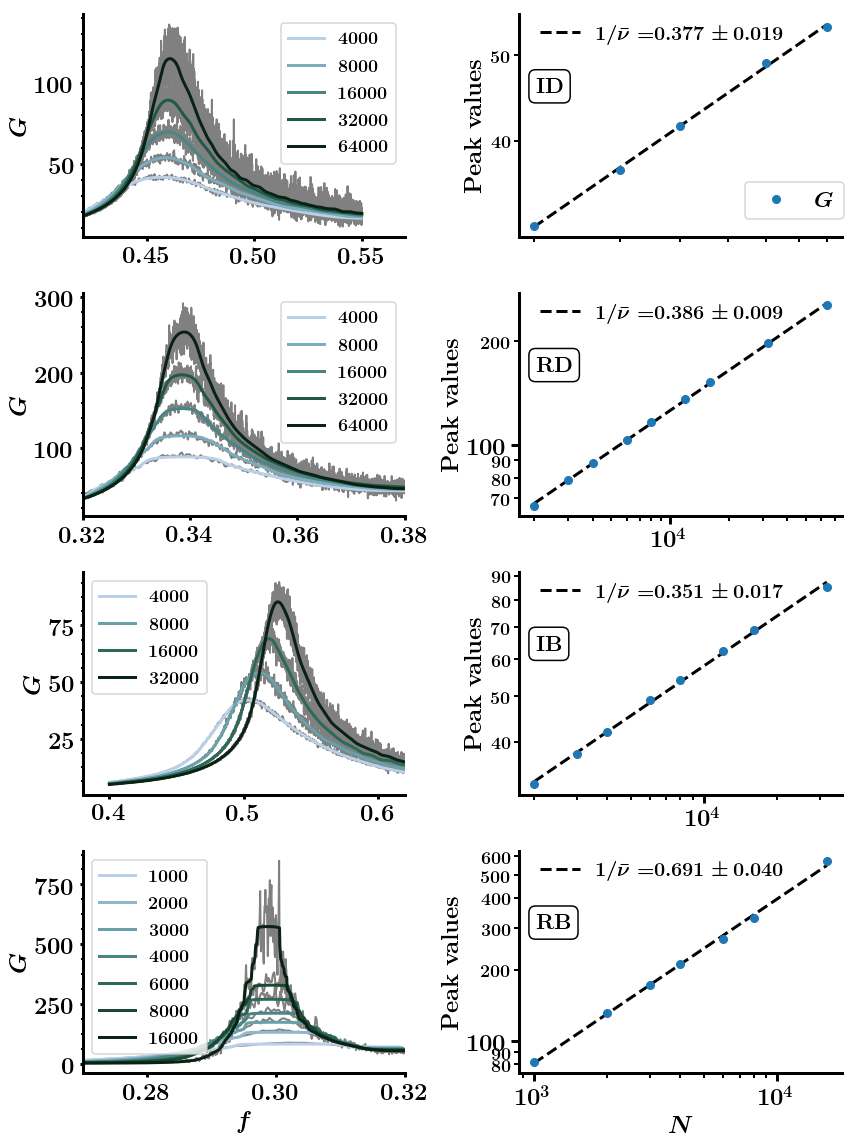

In [13]:
from matplotlib.ticker import FormatStrFormatter, MultipleLocator

def powerlaw(X, a, c):
    return c*np.array(X)**a

def getLinearReg(sizes, values, return_r2=False):

    X = np.log(sizes)
    Y = np.log(values)
    coeffs, cov = np.polyfit(X, Y, 1, cov=True)
    errors = np.sqrt(np.diag(cov))
    
    intercept = coeffs[1]
    slope = coeffs[0]
    y_error = 3*errors[0] ## Use three times standard error
    Y_pred = intercept + X*slope
    
    if return_r2:
        return np.exp(Y_pred), slope, linear_regressor.score(X, Y)
    return np.exp(Y_pred), slope, y_error

meank = 5
attacks = ['Deg', 'DegU', 'Btw', 'BtwU']

fminmax_values = {
    'Ran': (0.72, 0.87), 
    'Deg': (0.4, 0.55), 
    'DegU': (0.315, 0.38),
    'Btw': (0.4, 0.65), 
    'BtwU': (0.26, 0.32)
}

args = dict(itern=200, alph=5e-4, ep=1e-2, scale='large', plotflag=0, diagflag=0) 

ncols = 2
nrows = 4
fig, axes = plt.subplots(figsize=(6*ncols, 4*nrows), ncols=ncols, nrows=nrows)

for k, attack in enumerate(attacks):
    print(attack)
    
    ax = axes[k,0]
 
    if attack == 'Deg':
        N_values = [4000, 8000, 16000, 32000, 64000]
        xlim = (0.42, 0.57)
    elif attack == 'DegU':
        N_values = [4000, 8000, 16000, 32000, 64000]
        xlim = (0.32, 0.38)
    elif attack == 'Btw':
        N_values = [4000, 8000, 16000, 32000]
        xlim = (0.38, 0.62)
    elif attack == 'BtwU':
        N_values = [1000, 2000, 3000, 4000, 6000, 8000, 16000]
        xlim = (0.27, 0.32)  
    
    colors = sns.cubehelix_palette(len(N_values), start=2, rot=0.3, 
                                       light=0.8, dark=0.1)
    
    ax.set_xlim(xlim)
    
    net_dir_name = '../networks/ER/ER_k5.00'
    fmin, fmax = fminmax_values[attack]

    deriv_values = []
    for i, N in enumerate(N_values):
    
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)

        f, deriv, deriv_np = np.loadtxt(data_file)
        deriv_values.append([N, f, deriv])
        ax.plot(f, -deriv_np, color='grey', linewidth=2)
        
    for i, (N, f, deriv) in enumerate(deriv_values):    
        ax.plot(f, -deriv, label=r'${{{}}}$'.format(N), color=colors[i])
        
    if k == 3:
        ax.set_xlabel(r'$f$', fontsize=24)
    #ax.set_ylabel(r'$-\frac{\partial \log S_1}{\partial f}$', fontsize=32)
    ax.set_ylabel(r'$G$', fontsize=24)
    ax.legend(loc='best', fontsize=18)
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=18)

for k, attack in enumerate(attacks):
    print(attack)
    if attack == 'Deg':
        N_values = [2000, 3000, 4000, 6000, 8000]
    elif attack == 'DegU':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000, 64000]
    elif attack == 'Btw':
        N_values = [2000, 3000, 4000, 6000, 8000, 12000, 16000, 32000]
    elif attack == 'BtwU':
        N_values = [1000, 2000, 3000, 4000, 6000, 8000, 16000]
     

    net_dir_name = '../networks/ER/ER_k5.00'
    fmin, fmax = fminmax_values[attack]
    max_values = []
    for N in N_values:
    
        network = 'ER_k{:.2f}_N{:d}'.format(meank, N)
        base_file_name = 'TVRegDiff_itern{}_alph{}_ep{}_{}_fmin{:.4f}_fmax{:.4f}.txt'.format(args['itern'], args['alph'], 
                                                                                             args['ep'], 
                                                                                             attack, fmin, fmax)
        data_file = os.path.join(net_dir_name, network, base_file_name)

        f, deriv, deriv_np = np.loadtxt(data_file)
        max_pos = np.argmin(deriv)
        max_value = -np.min(deriv)
        max_values.append(max_value)

    max_values = np.array(max_values)

    
    ax = axes[k,1]
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)

    Y_pred, slope, y_err = getLinearReg(N_values, max_values)


    ax.set_ylabel(r'$\mathrm{Peak\;values}$', fontsize=24)
    if k == 3:
        ax.set_xlabel(r'$N$', fontsize=24)

    label = r'$1/\bar{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(N_values, Y_pred, '--', color='black', label=label)
    if k == 0:
        #ax.plot(N_values, max_values, 'o', markersize=8, label=r'$- \frac{\partial \log(S_1)}{\partial f}$')
        ax.plot(N_values, max_values, 'o', markersize=8, label=r'$G$')
    else:
        ax.plot(N_values, max_values, 'o', markersize=8)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    #print(max_values)
    ax.set_xticklabels([], minor=True)
    ax.yaxis.set_major_formatter(FormatStrFormatter(r'$%d$'))
    ax.yaxis.set_minor_formatter(FormatStrFormatter(r'$%d$'))
    
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    #ax.text(0.92, 0.1, attack_dict[attack], fontsize=22, 
    ax.text(0.05, 0.65, attack_dict[attack], fontsize=22, 
            transform=ax.transAxes, horizontalalignment='left', bbox=bbox)
    
    if k == 0:
        handles, labels = ax.get_legend_handles_labels()
        legend1 = ax.legend([handles[1]], [labels[1]], 
                            #loc=(0.03, 0.6), 
                            loc=(0.7, 0.08), 
                            fontsize=22)
        ax.add_artist(legend1)
        ax.legend([handles[0]], [labels[0]], fontsize=20, loc=(0.04, 0.83), frameon=False)
    else:
        ax.legend(fontsize=20, loc=(0.04, 0.83), frameon=False)
    
    inverse_err = (1/slope**2) * (y_err)
    print('{}\t{:.3f} +- {:.3f}'.format(attack, slope, y_err))
    print('\t{:.3f} +- {:.3f}'.format(1/slope, inverse_err))

    
sns.despine()
plt.tight_layout()

plt.show()